In [82]:
import numpy
import numpy.random
from scipy import fft
from scipy import signal
from matplotlib import pyplot
from IPython.lib.display import Audio

SAMPLING_FREQUENCY = 48_000
SAMPLING_PERIOD = 1 / SAMPLING_FREQUENCY


def plot_with_fft(f, duration, xlimit, xfreqlimit):
    sample_count = duration * SAMPLING_FREQUENCY
    x = numpy.linspace(0.0, duration, sample_count, endpoint=False)
    y = f(x)
    yf = fft.fft(y)
    xf = fft.fftfreq(sample_count, SAMPLING_PERIOD)[: sample_count // 2]

    axis = pyplot.gca()
    axis.set_xlim([0, xlimit])
    pyplot.plot(x, y)
    pyplot.grid()
    pyplot.show()

    axis = pyplot.gca()
    axis.set_xlim([0, xfreqlimit])
    pyplot.plot(xf, 2.0 / sample_count * numpy.abs(yf[0 : sample_count // 2]))
    pyplot.grid()
    pyplot.show()

    spec_f, spec_t, spec_Sxx = signal.spectrogram(y, SAMPLING_FREQUENCY)
    pyplot.pcolormesh(spec_t, spec_f, spec_Sxx, shading="gouraud")
    pyplot.ylabel("Frequency [Hz]")
    pyplot.xlabel("Time [sec]")
    pyplot.show()

    display(Audio(y, rate=SAMPLING_FREQUENCY, autoplay=False))

In [93]:
def noise(envelope):
    def f(t):
        return envelope(t) * numpy.random.uniform(-1.0, 1.0, len(t))

    return f


def unmodulated_sin(frequency, envelope):
    def f(t):
        return envelope(t) * numpy.sin(frequency * 2.0 * numpy.pi * t)

    return f


def phase_modulated_sin(carrier_hz, modulation_index, modulation_function, envelope):
    def f(t):
        return envelope(t) * numpy.sin(
            carrier_hz * 2.0 * numpy.pi * t + modulation_index * modulation_function(t)
        )

    return f


def ads_envelope(attack_time, attack_level, decay_time, sustain_level):
    def f(t):
        attack_region = t < attack_time
        decay_region = numpy.logical_and(
            t >= attack_time, t < (attack_time + decay_time)
        )
        sustain_region = t >= (attack_time + decay_time)
        attack_function = lambda t: (attack_level / attack_time) * t
        decay_function = (
            lambda t: (-(attack_level - sustain_level) / decay_time) * (t - attack_time)
            + attack_level
        )
        sustain_function = sustain_level
        return numpy.piecewise(
            t,
            [attack_region, decay_region, sustain_region],
            [attack_function, decay_function, sustain_function],
        )

    return f

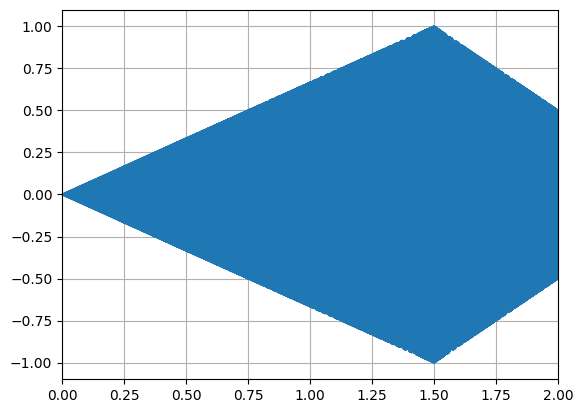

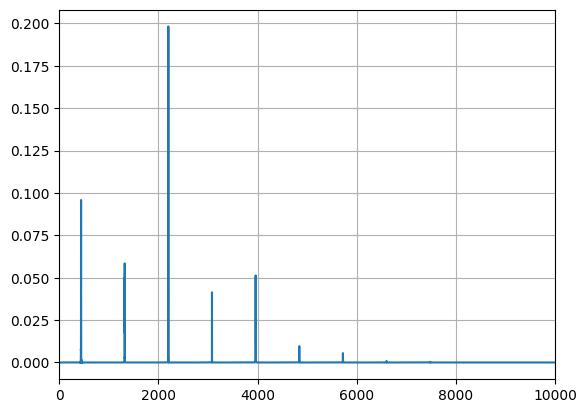

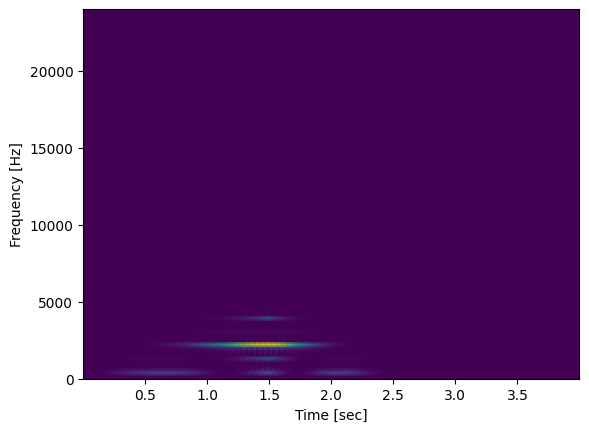

In [84]:
modulator = unmodulated_sin(440.0 * 2.0, ads_envelope(1.5, 1.0, 1, 0.0))
carrier = phase_modulated_sin(440.0, 4.0, modulator, ads_envelope(1.5, 1.0, 1, 0.0))
plot_with_fft(carrier, duration=4, xlimit=2, xfreqlimit=10_000)

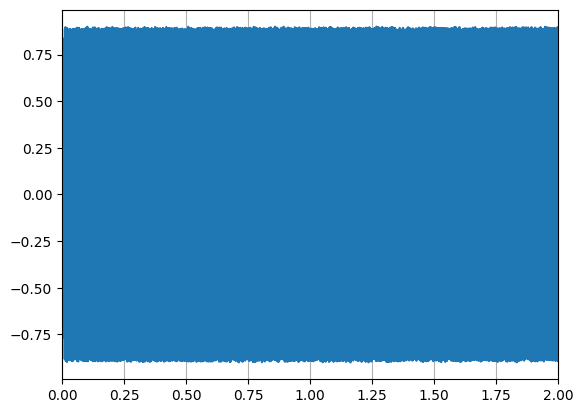

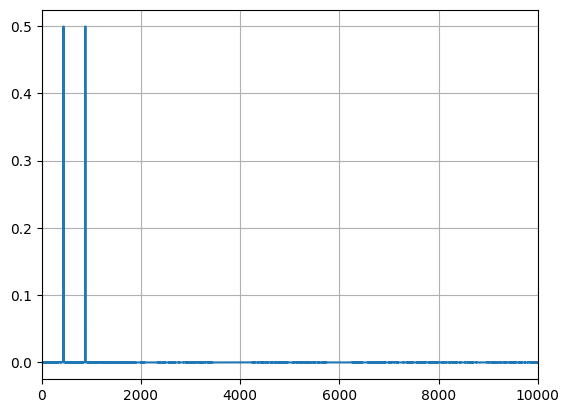

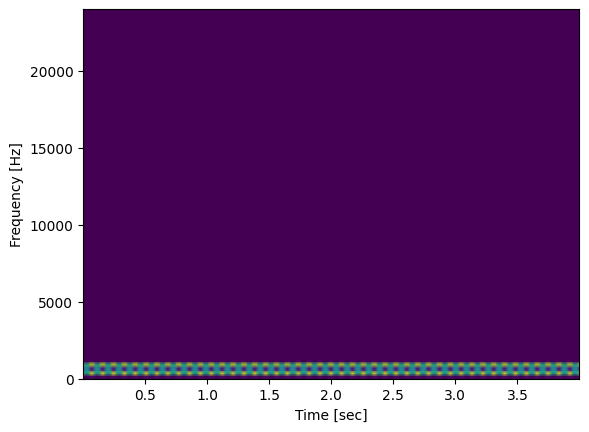

In [100]:
modulator = noise(ads_envelope(0.01, 1.0, 0.01, 1.0))
carrier1 = phase_modulated_sin(
    440.0, 0.05, modulator, ads_envelope(0.01, 1.0, 0.01, 1.0)
)
carrier2 = phase_modulated_sin(
    880.0, 0.05, modulator, ads_envelope(0.01, 1.0, 0.01, 1.0)
)
plot_with_fft(
    lambda t: (carrier1(t) + carrier2(t)) / 2.0, duration=4, xlimit=2, xfreqlimit=10_000
)